In [1]:
from numpy import inf
from numpy import nan
import math
import itertools
import ProbGraphGenerator as pg
import numpy as np
import pandas as pd
import itertools

<center><h1>Properties of the Aggregation Process</h1></center>

<h3>Theoretical Properties of Aggregation Function</h3>

<ol>
<li>Always expect some sort of output</li>
<li>If same set of probabiltistic frameworks are inserted we expect the result to be equal to one of the inputs</li>
<li>If one graph is input then we expect the same graph to come out</li>
<li>Symmetrical, so that order of aggregation does not matter</li>
<li>Mixture thing</li>
<li>Minimal distance between two probability distributions is minimal</li>

</ol>

<h3>Theoretical Properties of Query Function</h3>

<ol>

<li>If we have a query agent, who is querying a set of probabilistic graphs who have the same set of arguments, then we expect the result to be the proportion of the net positives/negatives/neutrals</li>

</ol>

Select List of Negative and Positive Arguments

In [2]:
from ipywidgets import *
from IPython.display import display
from ipywidgets import widgets

textPos = widgets.Text(description='List of Positive Arguments', width=500)
textNeg = widgets.Text(description='List of Negative Arguments', width=500)
display(textPos)
display(textNeg)

# list of user provided args
posArgs = []
negArgs = []

def handle_submit(sender):
    if sender == textPos:
        splitlist = (textPos.value).split(",")
        args = [int(a) for a in splitlist]
        posArgs.extend(args)
    if sender == textNeg:
        splitlist = (textNeg.value).split(",")
        args = [int(a) for a in splitlist]
        negArgs.extend(args)
        
    print(posArgs)
    print(negArgs)

    
textPos.on_submit(handle_submit)
textNeg.on_submit(handle_submit)



[0, 1]
[]
[0, 1]
[2]


In [3]:
allAgents = []

textAgent = widgets.Text(description='Insert an Agent', width=500)
display(textAgent)



def handle_new_agent(sender):
    
    splitlist = (textAgent.value).split(",")
    agentArgs = [int(a) for a in splitlist[0:-1]]
    agentTotals = []
    posFound = list(set(agentArgs).intersection(posArgs))
    negFound = list(set(agentArgs).intersection(negArgs))
    polarity = splitlist[-1]
    print(posFound)
    agentTotals = (posFound,negFound, polarity)
    
    allAgents.append(agentTotals)
    
textAgent.on_submit(handle_new_agent)

[0, 1]
[0]
[0]


In [34]:
allAgents


[([0, 1], [2], '+'), ([0], [2], '+'), ([0], [], '+')]

<h3>Testing Different Aggregation Approaches</h3>

In [35]:


graphDistribs = [] # Not needed when we have the graphDistribsGlobal
everyGraphProduced = np.unique(pg.generateGraphsGivenSetsOfArgs(posArgs, negArgs), axis=0)
graphDistribsGlobal = []
probDistribs = []
argumentsInAgents = []
polarities = []
agentsStringified = []

for agent in allAgents:
    graphDistribsGlobalAgents = []
    everyGraphProducedAgent = []
    agPosArgs = agent[0]
    agNegArgs = agent[1]
    polarity = agent[2]
    
    argumentsInAgents.append([agPosArgs + agNegArgs])
    polarities.append(polarity)
    
    agentsStringified.append(str(agent))
    
    # generate the plausible graphs for this agent
    posArgsIdx = list(range(0,len(agPosArgs)))
    negArgsIdx = list(range(len(agPosArgs), len(agPosArgs)+len(agNegArgs)))
    x,y = pg.calculateProbabilityDistribution(posArgsIdx, negArgsIdx, polarity)
    
    # Generate an initial probability distribution for these graphs
    initialProbDist = [1/len(x)] * len(x)
    graphDistribs.append(x)
    probDistribs.append(initialProbDist)
    
    # Convert the graphs into a global contribution, needed so that we can compare different agents of different sizes
    noArgTypes = len(posArgs) + len(negArgs)
    
    
    allAttacks = list(itertools.product(list(agPosArgs+agNegArgs), repeat=2))
    allAttacksIdx = []
    for attack in allAttacks:
        ptn = ((attack[0]+1)*noArgTypes)- ((noArgTypes+1) - attack[1])+1
        allAttacksIdx.append(ptn)
    
    for g in x:
        #globalContribution = np.zeros(noArgTypes*noArgTypes)
        globalContribution = np.full((noArgTypes*noArgTypes), np.inf)
        globalContribution[allAttacksIdx] = g
        graphDistribsGlobalAgents.append(globalContribution)
    
    graphDistribsGlobal.append(graphDistribsGlobalAgents)
    
    for g in y:
        #globalContribution = np.zeros(noArgTypes*noArgTypes)
        globalContribution = np.full((noArgTypes*noArgTypes), np.inf)
        globalContribution[allAttacksIdx] = g
    


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0.]]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]]
[[ inf  inf  inf  inf   0.   0.  inf   1.   0.]
 [ inf  inf 

<h3>Approach 1 - No Enrichment</h3>

In [36]:
allProbDistribs = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    for graph in agentGraphs:
        i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
        allProbDistribs[i,agentIdx] = 1

allProbDistribs

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

<h3>Approach 2 - Higher Enrichment</h3>

In [37]:
def checkBiDirAttacks(graph):
    
    argsList = range(0,int((math.sqrt(len(graph)))))
    dualLocations =  list(itertools.combinations(argsList, 2))
    
    for loc in dualLocations:

        noOfArgs = int(math.sqrt(len(graph)))
        pos = (loc[0] * noOfArgs) + loc[1]
        counterPos = (loc[1] * noOfArgs) + loc[0]
            
        net = graph[pos] + graph[counterPos]
        
        if net == 2:
            graph[pos] = 2
            graph[counterPos] = 2
        
    
    return graph

In [38]:
allProbDistribs2 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is same than he can enrich
            if agentinfs == ginfs:
                i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
                allProbDistribs2[i,agentIdx] = 1
            
            # If the agent is smaller than he can enrich
            if agentinfs > ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('-----------------')
                enrich = np.array_equal(multiple, graph)
                if enrich:
                    print(enrich)
                    allProbDistribs2[everyIdx,agentIdx] = 1
                
print(allProbDistribs2)                

changing agent-----*******
changing agent-----*******
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  0.  1.  1.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  2.  0.  2.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  0.  0.  0.  2.  1.  2.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
-----------------
True
[ 0.  0.  1.  

<h3>Approach 3 - Lower Enrichment</h3>

In [39]:
allProbDistribs3 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            print(everyIdx, g)
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is same than he can enrich
            if agentinfs == ginfs:
                i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
                print(i)
                allProbDistribs3[i,agentIdx] = 1
            
            # If the agent is larger than he can enrich
            if agentinfs < ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('-----------------')
                enrich = np.array_equal(multiple, y)
                polarityMatch = (polarities[agentIdx] == pg.getGraphPolarityMixedGraphSize(g, posArgs, negArgs))
                if enrich and polarityMatch:
                    print(enrich)
                    allProbDistribs3[everyIdx,agentIdx] = 1
                
print(allProbDistribs3)     

changing agent-----*******
0 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
4
1 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
4
2 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
4
3 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.]
4
4 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
4
5 [ 0.  0.  0.  0.  0.  1.  0.  1.  0.]
4
6 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
4
7 [ 0.  0.  0.  0.  0.  1.  1.  1.  0.]
4
8 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
4
9 [ 0.  0.  1.  0.  0.  0.  0.  1.  0.]
4
10 [ 0.  0.  1.  0.  0.  0.  1.  0.  0.]
4
11 [ 0.  0.  1.  0.  0.  0.  1.  1.  0.]
4
12 [ 0.  0.  1.  0.  0.  1.  0.  0.  0.]
4
13 [ 0.  0.  1.  0.  0.  1.  0.  1.  0.]
4
14 [ 0.  0.  1.  0.  0.  1.  1.  0.  0.]
4
15 [ 0.  0.  1.  0.  0.  1.  1.  1.  0.]
4
16 [  0.   0.  inf   0.   0.  inf  inf  inf  inf]
[  0.   0.  inf   0.   0.  inf  inf  inf  inf]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
True
17 [  0.  inf   0.  inf  inf  inf   0.  inf   0.]
[  0.  inf   0.  inf  inf  inf   0.  inf   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
--

<h3>Approach 4 - Higher and Lower Enrichment</h3>

In [40]:
allProbDistribs4 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is same than he can enrich
            if agentinfs == ginfs:
                i = (np.where((everyGraphProduced == graph).all(axis=1)))[0][0]
                allProbDistribs4[i,agentIdx] = 1
            
            # If the agent is smaller than he can enrich
            if agentinfs > ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('------smaller agent------')
                enrich = np.array_equal(multiple, graph)
                if enrich:
                    print(enrich)
                    allProbDistribs4[everyIdx,agentIdx] = 1
            
            # If the agent is larger than he can enrich
            if agentinfs < ginfs:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('------larger agent-------')
                enrich = np.array_equal(multiple, y)
                polarityMatch = (polarities[agentIdx] == pg.getGraphPolarityMixedGraphSize(g, posArgs, negArgs))
                if enrich and polarityMatch:
                    print(enrich)
                    allProbDistribs4[everyIdx,agentIdx] = 1
                
print(allProbDistribs4)     

changing agent-----*******
[  0.   0.  inf   0.   0.  inf  inf  inf  inf]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
True
[  0.  inf   0.  inf  inf  inf   0.  inf   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
[  0.  inf   0.  inf  inf  inf   1.  inf   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
[  0.  inf   1.  inf  inf  inf   0.  inf   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
[  0.  inf   2.  inf  inf  inf   2.  inf   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
[  0.  inf  inf  inf  inf  inf  inf  inf  inf]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
True
[ inf  inf  inf  inf   0.   0.  inf   0.   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
[ inf  inf  inf  inf   0.   0.  inf   1.   0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
------larger agent-------
[ inf  inf  inf  inf   0.   1.  inf   0.   0.]
[ 0.  0.  0.  0.  0.  1.  0.

In [41]:
print(allProbDistribs4)  

[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]]


<h3>Approach 5 - Enrichment the largest graph</h3>

In [42]:
allProbDistribs5 = np.zeros((len(everyGraphProduced),len(graphDistribsGlobal)))

pnts = range(0, int(math.sqrt(len(everyGraphProduced[0]))))
dualLocations = list(itertools.combinations(pnts, 2))

for agentIdx, agentGraphs in enumerate(graphDistribsGlobal):
    
    probDistrib = [0]*len(everyGraphProduced)
    
    print('changing agent-----*******')
    
    for graph in agentGraphs:

        for everyIdx, g in enumerate(everyGraphProduced):
            
            ginfs = np.sum(g == inf)
            agentinfs = np.sum(graph == inf)
            
            # If the agent is smaller than he can enrich
            # we will check to see if the graph comparing too is the largest graph
            if ginfs == 0:
                
                x = checkBiDirAttacks(np.copy(graph))
                y = checkBiDirAttacks(np.copy(g))
                
                multiple = x * y
                np.isnan(multiple)
                multiple[np.isnan(multiple)] = inf
                multiple[np.where(multiple==4)] = multiple[np.where(multiple==4)] / 2
                
                print(y)
                print(graph)
                print('-----------------')
                enrich = np.array_equal(multiple, graph)
                if enrich:
                    print(enrich)
                    allProbDistribs5[everyIdx,agentIdx] = 1
                
print(allProbDistribs5)     

changing agent-----*******
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  0.  0.  0.  0.  1.  1.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
True
[ 0.  0.  0.  0.  0.  2.  0.  2.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  0.  0.  0.  1.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
True
[ 0.  0.  0.  0.  0.  2.  1.  2.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  1.  0.  0.  0.  0.  1.  0.]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
-----------------
[ 0.  0.  2.  0.  0.  0

In [43]:
sumallProbDistribs = allProbDistribs / (allProbDistribs != 0).sum(0)
sumallProbDistribs2 = allProbDistribs2 / (allProbDistribs2 != 0).sum(0)
sumallProbDistribs3 = allProbDistribs3 / (allProbDistribs3 != 0).sum(0)
sumallProbDistribs4 = allProbDistribs4 / (allProbDistribs4 != 0).sum(0)
sumallProbDistribs5 = allProbDistribs5 / (allProbDistribs5 != 0).sum(0)


In [44]:
net = np.sum(sumallProbDistribs, axis=1) / len(allAgents)
net2 = np.sum(sumallProbDistribs2, axis=1) / len(allAgents)
net3 = np.sum(sumallProbDistribs3, axis=1) /  len(allAgents)
net4 = np.sum(sumallProbDistribs4, axis=1) / len(allAgents)
net5 = np.sum(sumallProbDistribs5, axis=1) / len(allAgents)

In [65]:
print(net4)
print(everyGraphProduced)

[ 0.01515152  0.01515152  0.01515152  0.01515152  0.04292929  0.01515152
  0.04292929  0.01515152  0.09848485  0.09848485  0.01515152  0.01515152
  0.09848485  0.09848485  0.04292929  0.01515152  0.04292929  0.01515152
  0.01515152  0.09848485  0.01515152  0.09848485  0.          0.
  0.02777778  0.          0.02777778  0.        ]
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   1.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   1.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   1.   1.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   1.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   1.   1.   0.]
 [  0.   0.   1.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   1.   0.   1. 

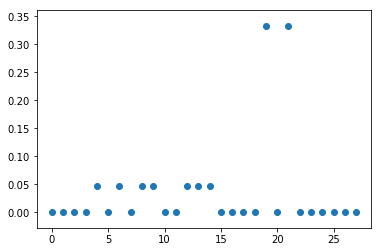

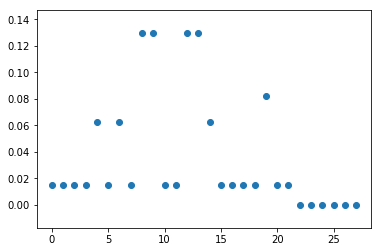

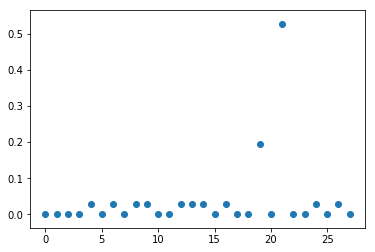

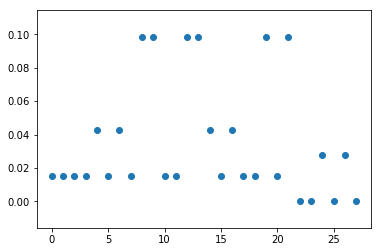

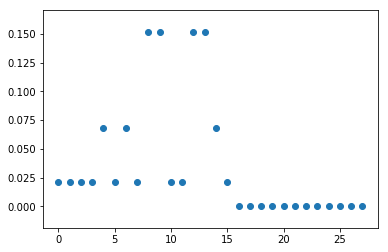

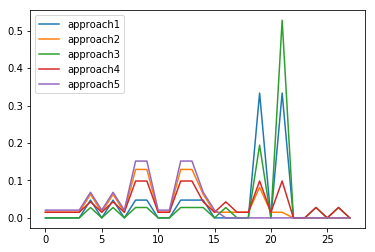

In [64]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['backend'] = "Qt4Agg"
import pylab
import numpy as np


x = range(0,len(net))  # 100 evenly-spaced values from 0 to 50


pylab.scatter(x, net)
pylab.show()
pylab.scatter(x, net2)
pylab.show()
pylab.scatter(x, net3)
pylab.show()
pylab.scatter(x, net4)
pylab.show()
pylab.scatter(x, net5)
pylab.show()

pylab.plot(x, net, label='approach1')
pylab.plot(x, net2, label='approach2')
pylab.plot(x, net3, label='approach3')
pylab.plot(x, net4, label='approach4')
pylab.plot(x, net5, label='approach5')
pylab.legend()
pylab.show()

<h1>Properties of Aggregation Functions</h2>

Test the following properties:

<ol>
<li>Identity</li>
<li>Same set of agents produce same graph</li>
<li>Order not important</li>
</ol>

<h1>Query Agent</h1>
<ul>
<li>Some distributions don't give graphs for agents with more nodes than those in the training population</li>
<li>Some distributions don't give graphs for agents with less nodes</li>
</ul>


Approaches to picking out a graph for our agents
<ul>
<li>We can restrict ourselves to graphs who have our nodes exactly
<ul>
<li>What if all those graphs have no mass on them, i.e. our training set doesn't contain similar agents?</li>
</ul>
</li>

<li>We can use graphs who have at least one similar node in its grounded extension 
<ul>
<li>We are travelling both up and down the graph</li>
<li>This is a bit weird intuitively because we would never give lower graphs to an agent, because it would mean he would have to ignore one or more of his arguments to use such graphs</li>
</ul>
</li>

<li>In our classifier experiment only concerned with predictive capacity so can look at polarities only</li>
<li>In this case taking the approach of 'at least one arg in g.e' works fine</li>
</ul>


In [47]:
everyGraphProduced

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,

In [48]:
groundedExtensionsEveryGraph = []
[groundedExtensionsEveryGraph.append(pg.getGroundedExtensionMixedGraphSize(thegraph, posArgs, negArgs)) for thegraph in everyGraphProduced]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [49]:
allEveryGraphPols = []
for g in groundedExtensionsEveryGraph:
    if (list(g) == []):
        allEveryGraphPols.append('n')
        continue
    if (set(g) <= set(posArgs)):
        allEveryGraphPols.append('+')
        continue
    if (set(g) <=set(negArgs)):
        allEveryGraphPols.append('-')
        continue
    else:
        allEveryGraphPols.append(' ')
        

<h3>Approach 1: Matching grounded extension</h3>

In [50]:
d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'nothingChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    
    match = set(groundedExtensionsEveryGraphSingle).intersection(queryAgent)
    if match:
        groundedMatches.append(i)
        

In [51]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]

In [52]:
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.333333,0.736364,0.277778,0.636364,0.833333
negativeChance,0.000000,0.000000,0.000000,0.000000,0.000000
neutralChance,0.000000,0.000000,0.000000,0.000000,0.000000
nothingChance,0.000000,0.030303,0.000000,0.030303,0.041667


<h3>Approach 2: Exact Grounded Extension</h3>

In [53]:
d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'nothingChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    
    match = set(groundedExtensionsEveryGraphSingle) == set(queryAgent)
    if match:
        groundedMatches.append(i)
        
print(groundedExtensionsEveryGraph)
print(everyGraphProduced)
groundedMatches

[[0, 1, 2], [0, 2], [1, 2], [2], [0, 1], [0], [0, 1], [], [0, 1], [0, 1], [1], [], [0, 1], [0, 1], [0, 1], [], [0, 1], [0, 2], [2], [0], [], [0], [1, 2], [2], [1], [], [1], [2]]
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   1.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   1.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   1.   1.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   1.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   1.   1.   0.]
 [  0.   0.   1.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   1.   0.   1.   0.]
 [  0.   0.   1.   0.   0.   1.   1.   0.   0.]
 [  0.   0.   1.   0.   0.   1.   1.   1.   0.]
 [  0.   0.  inf   0.   0.  inf  inf  inf  inf]
 [  0.

[10, 24, 26]

In [54]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]

In [55]:
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.0,0.015152,0.055556,0.070707,0.020833
negativeChance,0.0,0.000000,0.000000,0.000000,0.000000
neutralChance,0.0,0.000000,0.000000,0.000000,0.000000
nothingChance,0.0,0.000000,0.000000,0.000000,0.000000


<h3>Approach 3: Exact or Higher Grounded Extension</h3>

In [56]:
d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'nothingChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    match = set(queryAgent) <= set(groundedExtensionsEveryGraphSingle)
    print('q:', queryAgent, 'g:', groundedExtensionsEveryGraphSingle, ' ',match)
    if match:
        groundedMatches.append(i)
        
groundedMatches
groundedMatchesProbs = [n[i] for i in groundedMatches]
print(groundedMatchesProbs)

q: [1] g: [0, 1, 2]   True
q: [1] g: [0, 2]   False
q: [1] g: [1, 2]   True
q: [1] g: [2]   False
q: [1] g: [0, 1]   True
q: [1] g: [0]   False
q: [1] g: [0, 1]   True
q: [1] g: []   False
q: [1] g: [0, 1]   True
q: [1] g: [0, 1]   True
q: [1] g: [1]   True
q: [1] g: []   False
q: [1] g: [0, 1]   True
q: [1] g: [0, 1]   True
q: [1] g: [0, 1]   True
q: [1] g: []   False
q: [1] g: [0, 1]   True
q: [1] g: [0, 2]   False
q: [1] g: [2]   False
q: [1] g: [0]   False
q: [1] g: []   False
q: [1] g: [0]   False
q: [1] g: [1, 2]   True
q: [1] g: [2]   False
q: [1] g: [1]   True
q: [1] g: []   False
q: [1] g: [1]   True
q: [1] g: [2]   False
[0.020833333333333332, 0.020833333333333332, 0.068452380952380945, 0.068452380952380945, 0.15178571428571427, 0.15178571428571427, 0.020833333333333332, 0.15178571428571427, 0.15178571428571427, 0.068452380952380945, 0.0, 0.0, 0.0, 0.0]


In [57]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    print(n)
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]

[ 0.          0.          0.          0.          0.04761905  0.
  0.04761905  0.          0.04761905  0.04761905  0.          0.
  0.04761905  0.04761905  0.04761905  0.          0.          0.          0.
  0.33333333  0.          0.33333333  0.          0.          0.          0.
  0.          0.        ]
[ 0.01515152  0.01515152  0.01515152  0.01515152  0.06277056  0.01515152
  0.06277056  0.01515152  0.12943723  0.12943723  0.01515152  0.01515152
  0.12943723  0.12943723  0.06277056  0.01515152  0.01515152  0.01515152
  0.01515152  0.08181818  0.01515152  0.01515152  0.          0.          0.
  0.          0.          0.        ]
[ 0.          0.          0.          0.          0.02777778  0.
  0.02777778  0.          0.02777778  0.02777778  0.          0.
  0.02777778  0.02777778  0.02777778  0.          0.02777778  0.          0.
  0.19444444  0.          0.52777778  0.          0.          0.02777778
  0.          0.02777778  0.        ]
[ 0.01515152  0.01515152  0.01515152  

In [58]:
d 

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.333333,0.736364,0.277778,0.636364,0.833333
negativeChance,0.000000,0.000000,0.000000,0.000000,0.000000
neutralChance,0.000000,0.000000,0.000000,0.000000,0.000000
nothingChance,0.000000,0.030303,0.000000,0.030303,0.041667


<h3>Approach 4: Exact or Lower Grounded Extension</h3>


In [59]:
d = pd.DataFrame(np.zeros((4, 5)))
#d.set_index(['positiveChance','negativeChance', 'neutralChance', 'nothingChance'])
d.index = ['positiveChance','negativeChance', 'neutralChance', 'nothingChance']
d.columns = ['Apprch1','Apprch2', 'Apprch3', 'Apprch4', 'Apprch5']

queryAgent = [1]

groundedMatches = []

for i, groundedExtensionsEveryGraphSingle in enumerate(groundedExtensionsEveryGraph):
    
    match = set(groundedExtensionsEveryGraphSingle) <= set(queryAgent)
    if match:
        groundedMatches.append(i)

In [60]:
allnets = [net, net2, net3, net4, net5]

for netNo, n in enumerate(allnets):
    groundedMatchesProbs = [n[i] for i in groundedMatches]
    groundedMatchesSigns = [allEveryGraphPols[i] for i in groundedMatches]
    
    positiveChance = 0
    negativeChance = 0
    neutralChance = 0
    nothingChance = 0

    for i, sign in enumerate(groundedMatchesSigns):
        if sign == '+':
            positiveChance += groundedMatchesProbs[i]
            continue
        if sign == '-':
            negativeChance += groundedMatchesProbs[i]
            continue
        if sign == 'n':
            neutralChance += groundedMatchesProbs[i]
            continue
        else:
            nothingChance += groundedMatchesProbs[i]
            continue
            
    d.iloc[:,netNo] = [positiveChance, negativeChance, neutralChance, nothingChance]

In [61]:
d

,Apprch1,Apprch2,Apprch3,Apprch4,Apprch5
positiveChance,0.0,0.015152,0.055556,0.070707,0.020833
negativeChance,0.0,0.000000,0.000000,0.000000,0.000000
neutralChance,0.0,0.060606,0.000000,0.060606,0.062500
nothingChance,0.0,0.000000,0.000000,0.000000,0.000000


In [62]:
a = [2]
b = [0,2]

set(a) <= set(b)

True